## Trainied on all subject and test of 1 subject at person=0

### Importing the necessary pakages

In [1]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,LSTM,BatchNormalization,MaxPooling2D,Reshape
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from keras import regularizers
from keras.layers import LeakyReLU
from sklearn.model_selection import train_test_split

### Preprocessing the given dataset

In [2]:
def data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:500]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    return total_X,total_y



### Loading given dataset and chekcing their dimensions

In [3]:
## Loading the dataset


X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


### Checking the unique values and their counts in train and test data for every subject with plot

In [4]:
unique_values_train, value_counts_train = np.unique(person_train_valid, return_counts=True)
print("person_train_valid = ", end="")
# print unique values and their counts
for value, count in zip(unique_values_train, value_counts_train):
    print(f"{int(value)}:{count}", end=" ")

person_train_valid = 0:237 1:236 2:236 3:234 4:235 5:236 6:238 7:232 8:231 

In [5]:
unique_values_test, value_counts_test = np.unique(person_test, return_counts=True)
print("person_test = ", end="")
# print unique values and their counts
for value, count in zip(unique_values_test, value_counts_test):
    print(f"{int(value)}:{count}", end=" ")

person_test = 0:50 1:50 2:50 3:50 4:47 5:49 6:50 7:50 8:47 

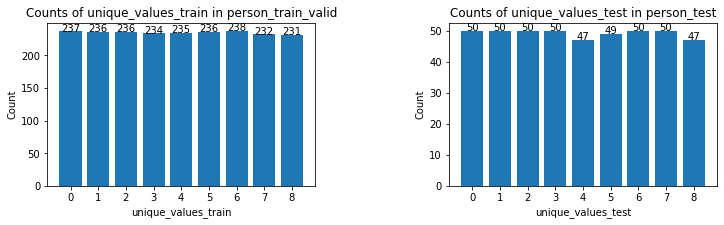

In [6]:
import matplotlib.pyplot as plt

# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))

# plotting the person_train_valid plot in the first subplot
ax1.bar(unique_values_train, value_counts_train)
for i, count in enumerate(value_counts_train):
    ax1.text(unique_values_train[i], count+0.1, str(count), ha='center')
ax1.set_xticks(unique_values_train)
ax1.set_xlabel('unique_values_train')
ax1.set_ylabel('Count')
ax1.set_title('Counts of unique_values_train in person_train_valid')

# plotting the person_test plot in the second subplot
ax2.bar(unique_values_test, value_counts_test)
for i, count in enumerate(value_counts_test):
    ax2.text(unique_values_test[i], count+0.1, str(count), ha='center')
ax2.set_xticks(unique_values_test)
ax2.set_xlabel('unique_values_test')
ax2.set_ylabel('Count')
ax2.set_title('Counts of unique_values_test in person_test')

# adjust spacing between subplots
plt.subplots_adjust(wspace=0.5)

# display the figure
plt.show()


### Extracting subject 1 data at person = 0 for train and test

## not running now for each person

In [7]:
train_valid_idx=np.where(person_train_valid == 0)
print(f"train_valid_idx for 1 sub of person_train_valid equals 0 is {np.array(train_valid_idx).shape} first bar in 1st plot")

# using obtained index we get X_train_valid values of that subject
X_train_valid_person_sub1=X_train_valid[train_valid_idx[0]]
print("X_train_valid_person_sub1 data for sub 1 shape is = ",np.array(X_train_valid_person_sub1).shape)

#similarly for y_train_valid data usings same index we get for sub 1
y_train_valid_person_sub1=y_train_valid[train_valid_idx[0]]
print("y_train_valid_person_sub1 data for sub 1 shape is = ",np.array(y_train_valid_person_sub1).shape)

train_valid_idx for 1 sub of person_train_valid equals 0 is (2, 237) first bar in 1st plot
X_train_valid_person_sub1 data for sub 1 shape is =  (237, 22, 1000)
y_train_valid_person_sub1 data for sub 1 shape is =  (237,)


In [8]:
test_idx=np.where(person_test==0)
print(f"test_idx for 1 sub of person_test equals 0 is {np.array(test_idx).shape} first bar in 2nd plot")

# using obtained index we get X_test values of that subject
X_test_person_sub1=X_test[test_idx[0]]
print("X_test_person_sub1 data for sub 1 shape is = ",np.array(X_test_person_sub1).shape)

#similarly for y_test data usings same index we get for sub 1
y_test_person_sub1=y_test[test_idx[0]]
print("y_test_person_sub1 data for sub 1 shape is = ",np.array(y_test_person_sub1).shape)

test_idx for 1 sub of person_test equals 0 is (2, 50) first bar in 2nd plot
X_test_person_sub1 data for sub 1 shape is =  (50, 22, 1000)
y_test_person_sub1 data for sub 1 shape is =  (50,)


In [9]:
np.array(X_test_person_sub1).shape

(50, 22, 1000)

### Preprocessing data

In [10]:
## Random splitting and reshaping the data
# First generating the training and validation indices using random splitting


#ind_valid = np.random.choice(237, 42, replace=False) #2115 375
#ind_train = np.array(list(set(range(237)).difference(set(ind_valid))))

ind_valid = np.random.choice(2115, 375, replace=False) #2117 375
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices for sub1
#(X_train, X_valid) = X_train_valid_person_sub1[ind_train], X_train_valid_person_sub1[ind_valid] 
#(y_train, y_valid) = y_train_valid_person_sub1[ind_train], y_train_valid_person_sub1[ind_valid]

# Creating the training and validation sets using the generated indices for all subject
(X_train, X_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]


In [11]:
y_valid.shape

(375,)

In [12]:

## Preprocessing the dataset
x_train,y_train = data_prep(X_train,y_train,2,2,True)


Shape of X after trimming: (1740, 22, 500)
Shape of X after maxpooling: (1740, 22, 250)
Shape of X after averaging+noise and concatenating: (3480, 22, 250)
Shape of X after subsampling and concatenating: (6960, 22, 250)


In [13]:
x_valid,y_valid = data_prep(X_valid,y_valid,2,2,True)


Shape of X after trimming: (375, 22, 500)
Shape of X after maxpooling: (375, 22, 250)
Shape of X after averaging+noise and concatenating: (750, 22, 250)
Shape of X after subsampling and concatenating: (1500, 22, 250)


In [14]:
X_test_prep, y_test_prep = data_prep(X_test_person_sub1, y_test_person_sub1, 2,2,True)
#X_test_prep,y_test_prep = data_prep(X_test,y_test,2,2,True)

Shape of X after trimming: (50, 22, 500)
Shape of X after maxpooling: (50, 22, 250)
Shape of X after averaging+noise and concatenating: (100, 22, 250)
Shape of X after subsampling and concatenating: (200, 22, 250)


In [15]:
print('Shape of testing set:',X_test_prep.shape)
print('Shape of testing labels:',y_test_prep.shape)
print()
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)

Shape of testing set: (200, 22, 250)
Shape of testing labels: (200,)

Shape of training set: (6960, 22, 250)
Shape of validation set: (1500, 22, 250)
Shape of training labels: (6960,)
Shape of validation labels: (1500,)


In [16]:
# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test_prep, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

Shape of training labels after categorical conversion: (6960, 4)
Shape of validation labels after categorical conversion: (1500, 4)
Shape of test labels after categorical conversion: (200, 4)


In [17]:
# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)

Shape of training set after adding width info: (6960, 22, 250, 1)
Shape of validation set after adding width info: (1500, 22, 250, 1)
Shape of test set after adding width info: (200, 22, 250, 1)


In [18]:
x_test.shape

(200, 22, 250, 1)

In [19]:
# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)

Shape of training set after dimension reshaping: (6960, 250, 1, 22)
Shape of validation set after dimension reshaping: (1500, 250, 1, 22)
Shape of test set after dimension reshaping: (200, 250, 1, 22)


### Shape of data

### CNN_LSTM
#### 4 Convolution block
#### FC+LSTM 
#### Activation = LeakyRelu
#### Filters = 20, 40, 80, 160

In [20]:
# Building the CNN model using sequential class
hybrid_cnn_lstm_model = Sequential()

#activation=LeakyReLU(alpha=0.2)
activation='relu'
# Conv. block 1
hybrid_cnn_lstm_model.add(Conv2D(filters=20, kernel_size=(10,1), padding='same', activation=activation, input_shape=(250,1,22)))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.5))

# Conv. block 2
hybrid_cnn_lstm_model.add(Conv2D(filters=40, kernel_size=(10,1), padding='same', activation=activation))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.5))

# Conv. block 3
hybrid_cnn_lstm_model.add(Conv2D(filters=80, kernel_size=(10,1), padding='same', activation=activation))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.5))

# Conv. block 4
hybrid_cnn_lstm_model.add(Conv2D(filters=160, kernel_size=(10,1), padding='same', activation=activation))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.5))

# FC+LSTM layers
hybrid_cnn_lstm_model.add(Flatten()) # Adding a flattening operation to the output of CNN block
hybrid_cnn_lstm_model.add(Dense((100))) # FC layer with 100 units
hybrid_cnn_lstm_model.add(Reshape((100,1))) # Reshape my output of FC layer so that it's compatible
hybrid_cnn_lstm_model.add(LSTM(160, dropout=0.6, recurrent_dropout=0.1, input_shape=(100,1), return_sequences=False))
hybrid_cnn_lstm_model.add(Reshape((1, 160)))
hybrid_cnn_lstm_model.add(LSTM(10, dropout=0.6, recurrent_dropout=0.1, input_shape=(100,1), return_sequences=False))

# Output layer with Softmax activation 
hybrid_cnn_lstm_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
hybrid_cnn_lstm_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 250, 1, 20)        4420      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 84, 1, 20)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 84, 1, 20)        80        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 84, 1, 20)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 84, 1, 40)         8040      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 1, 40)        0

In [21]:
x_test.shape

(200, 250, 1, 22)

In [22]:
# Model parameters
learning_rate = 1e-3
epochs = 80
hybrid_cnn_lstm_optimizer = keras.optimizers.Adam(lr=learning_rate)

C:\Users\swaga\AppData\Roaming\Python\Python39\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [23]:
# Compiling the model
hybrid_cnn_lstm_model.compile(loss='categorical_crossentropy',
                 optimizer=hybrid_cnn_lstm_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
hybrid_cnn_lstm_model_results = hybrid_cnn_lstm_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)



Epoch 1/80
109/109 [==============================] - 29s 234ms/step - loss: 1.3600 - accuracy: 0.2993 - val_loss: 1.3459 - val_accuracy: 0.3700
Epoch 2/80
109/109 [==============================] - 28s 260ms/step - loss: 1.2805 - accuracy: 0.4050 - val_loss: 1.2228 - val_accuracy: 0.4447
Epoch 3/80
109/109 [==============================] - 26s 235ms/step - loss: 1.2322 - accuracy: 0.4376 - val_loss: 1.1604 - val_accuracy: 0.4840
Epoch 4/80
109/109 [==============================] - 25s 226ms/step - loss: 1.1842 - accuracy: 0.4648 - val_loss: 1.1532 - val_accuracy: 0.4620
Epoch 5/80
109/109 [==============================] - 25s 226ms/step - loss: 1.1596 - accuracy: 0.4802 - val_loss: 1.2124 - val_accuracy: 0.3947
Epoch 6/80
109/109 [==============================] - 26s 236ms/step - loss: 1.1228 - accuracy: 0.4925 - val_loss: 1.1545 - val_accuracy: 0.4900
Epoch 7/80
109/109 [==============================] - 26s 238ms/step - loss: 1.0993 - accuracy: 0.5131 - val_loss: 1.1064 - val_ac

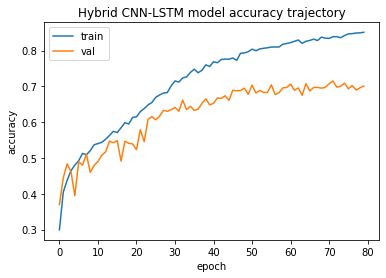

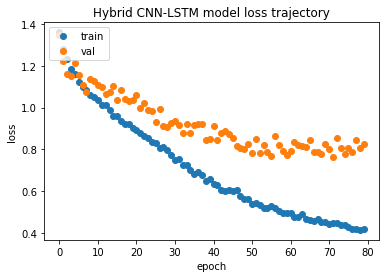

In [24]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['accuracy'])
plt.plot(hybrid_cnn_lstm_model_results.history['val_accuracy'])
plt.title('Hybrid CNN-LSTM model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['loss'],'o')
plt.plot(hybrid_cnn_lstm_model_results.history['val_loss'],'o')
plt.title('Hybrid CNN-LSTM model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [25]:
x_test.shape

(200, 250, 1, 22)

In [29]:
## Testing the hybrid CNN-LSTM model
print(f"before {x_test.shape}") #Double chekcing on dimensions 
hybrid_cnn_lstm_score = hybrid_cnn_lstm_model.evaluate(x_test, y_test, verbose=0)

print('Test accuracy of the hybrid CNN-LSTM model:',hybrid_cnn_lstm_score[1])
print(f"after {x_test.shape}") #Double chekcing on dimensions

before (200, 250, 1, 22)
Test accuracy of the hybrid CNN-LSTM model: 0.5049999952316284
after (200, 250, 1, 22)


7/7 [==============================] - 6s 94ms/step


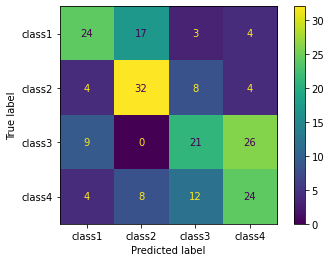

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Predict on test data
y_pred = hybrid_cnn_lstm_model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Compute confusion matrix
conf_mat = confusion_matrix(y_true_labels, y_pred_labels)

# Display confusion matrix
classes = ['class1', 'class2', 'class3', 'class4']
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=classes)
disp.plot()
plt.show()

In [28]:
from sklearn.metrics import classification_report
import numpy as np

# Predict on test data
y_pred = hybrid_cnn_lstm_model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Generate classification report
target_names = ['class1', 'class2', 'class3', 'class4']
report = classification_report(y_true_labels, y_pred_labels, target_names=target_names)

# Print classification report
print(report)


7/7 [==============================] - 1s 80ms/step
              precision    recall  f1-score   support

      class1       0.59      0.50      0.54        48
      class2       0.56      0.67      0.61        48
      class3       0.48      0.38      0.42        56
      class4       0.41      0.50      0.45        48

    accuracy                           0.51       200
   macro avg       0.51      0.51      0.51       200
weighted avg       0.51      0.51      0.50       200

